Author: Carlos Roberto de Melo
    
Date: 07/11/2020

Obj: Parametrizar o perfil pseudo-NFW apresentado em Collett et al. 2018. A parametrização é feita com gaussianas, de modo que possam ser adicionadas ao potencial do JAM mais tarde.

In [1]:
from mgefit import mge_fit_1d
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Definindo algumas funções úteis.
SQRT_TOW_PI = np.sqrt(2*np.pi)


#Perfil pseudo-NFW
def pNFW(rho_0, r_s, r):
    rho = rho_0/(r*(r_s**2 + r**2))
    return rho

#Realializa a deprojeção de 2d para 3d das gaussianas. Isso assume uma certa parametrização mge2d, um ângulo
    #de inclinação para deprojeção e um formato (oblate ou prolate)
def deprojection(mge2d, inc, shape):
        '''
        Return the 3D deprojected MGE coefficients
        '''
        mge3d = np.zeros_like(mge2d)
        if shape == 'oblate':
            qintr = mge2d[:, 2]**2 - np.cos(inc)**2
            if np.any(qintr <= 0):
                raise RuntimeError('Inclination too low q < 0')
            qintr = np.sqrt(qintr)/np.sin(inc)
            if np.any(qintr < 0.05):
                raise RuntimeError('q < 0.05 components')
            dens = mge2d[:, 0]*mge2d[:, 2] /\
                (mge2d[:, 1]*qintr*SQRT_TOW_PI)
            mge3d[:, 0] = dens
            mge3d[:, 1] = mge2d[:, 1]
            mge3d[:, 2] = qintr
        elif shape == 'prolate':
            qintr = np.sqrt(1.0/mge2d[:, 2]**2 -
                            np.cos(inc)**2)/np.sin(inc)
            if np.any(qintr > 10):
                raise RuntimeError('q > 10.0 conponents')
            sigmaintr = mge2d[:, 1]*mge2d[:, 2]
            dens = mge2d[:, 0] / (SQRT_TOW_PI*mge2d[:, 1] *
                                       mge2d[:, 2]**2*qintr)
            mge3d[:, 0] = dens
            mge3d[:, 1] = sigmaintr
            mge3d[:, 2] = qintr
        return mge3d


#Calcula a densidade luminosa de gaussianadas 3d para algum raio R
def luminosityDensity(mge3d, R, z):
        '''
        Return the luminosity density at coordinate R, z (in L_solar/pc^3)
        '''
        rst = 0.0
        ngauss = mge3d.shape[0]
        for i in range(ngauss):
            rst += mge3d[i, 0] * np.exp(-0.5/mge3d[i, 1]**2 *
                                        (R**2 + (z/mge3d[i, 2])**2))
        return rst

Iteration: 1  chi2: 2.205 Nonzero: 38/100
Iteration: 11  chi2: 1.315 Nonzero: 37/100
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Iteration: 15  chi2: 1.31 Nonzero: 36/36
############################################
 Computation time: 156.66 seconds
 Total Iterations:  15
Nonzero Gaussians:  36
 Unused Gaussians:  64
 Chi2: 1.31 
 STDEV: 0.02954
 MEANABSDEV: 0.007385
############################################
 Total_Counts      Sigma
############################################
  2.60935e-10    0.0707107
  2.10014e-10      0.14099
  1.36693e-11     0.160317
  8.38442e-12     0.231872
  1.83603e-10     0.259574
  1.46663e-10      0.42807
  3.94115e-11     0.519327
  1.47843e-10     0.718504
  3.07566e-11      1.00878
  1.18143e-10      1.12956
  4.76491e-11      1.58589
  9.46611e-11      1.72699
  1.30563e-10      2.49318
  9.21658e-11      3.50033
   6.0685e-11      4.23511
  4.14231e-11      4.91435
  1.13282e-10      6.16181
  1.16585e-10      8.6508

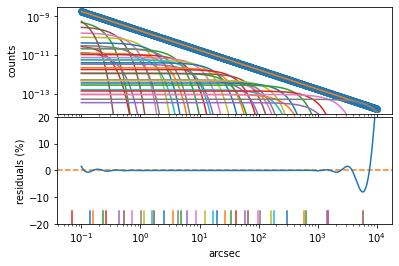

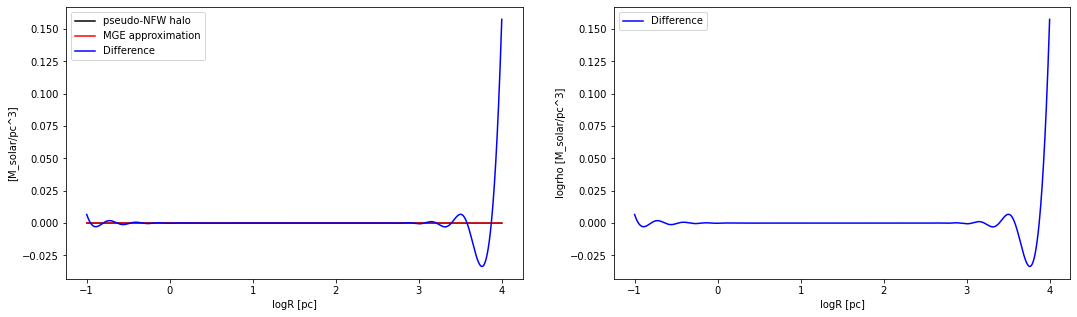

In [3]:
#Main code

r = np.logspace(np.log10(0.1), np.log10(10e3), 1500) #Cria valores espaçados em de um delta-log (requerido para o mge1d_fit). Unidade de pc
logr = np.log10(r)#Unidade de pc

#Definindo os parâmetros do gNFW
r_hl = 7.6e3   #half light radius [pc]
rs = 10*r_hl   #rs do modelo, fixado pelo paper [pc]
#rho_0 = 1.07e12  # [M_solar]  Obs:(1[M_solar/kpc^3] = 1e9[M_solar/pc^3])
rho_0 = 1.0 

#Calculando o perfil gNFW analítico e tomando o log para posterior plot
profile_DM = np.log10(pNFW(rho_0=rho_0, r_s=rs, r=r)) 

#Agora vamos realizar a parametrização em MGE 1d
r_mge2d = np.logspace(np.log10(0.1), np.log10(10e3), 1500) #Cria valores espaçados em de um delta-log (requerido para o mge1d_fit)
rho_mge2d = pNFW(rho_0=rho_0, r_s=rs, r=r_mge2d) #Perfil gNFW

#-------------Aqui é onde realmente começa a parametrização MGE--------------------------------

mge = mge_fit_1d.mge_fit_1d(r_mge2d, rho_mge2d, quiet=False, ngauss=100, plot=True)
mge_peak = mge.sol[0]         #Pico de cada gaussiana
mge_sigma = mge.sol[1]        #Sigma de cada gaussiana
#O resultado acima já está em M_sun/pc²

mge2d = np.zeros((len(mge_peak), 3)) #Agora iremos criar um array com o número de linhas igual ao número de
                                        #gaussianas e três colunas para armazenar os dados
mge2d[:, 0] = mge_peak     #Pico de cada gaussiana
mge2d[:, 1] = mge_sigma    #Sigma de cada gausiana
mge2d[:, 2] = 0.74         #qObs de cada gaussiana. 



#--------------A partir daqui vamos apenas comparar o perfil analítico com o perfil parametrizado. Em princípio
    #o necessário para o modelo JAM termina acima e só é necessário salvar os dados. ----------------------------#
#Here are some unit conversion
mge3d = deprojection(mge2d=mge2d, inc=np.pi/2, shape='oblate' )#Deprojeta o perfil 2d para 3d assumindo uma inclinação inc e um formato do elipsoide de velocidades 
mge_density = luminosityDensity(mge3d,r,0) #Densidade das MGE deprojetadas. Atenção as unidades de medida.

#Finalmente o perfil DM parametrizado pelo MGE.
profile_mge = np.log10(mge_density)#Aqui voltamos a multiplicar por 1e9 pois queremos comparar com o outro perfil, que tem unidades [M_sol/pc³]

# plot the density profile of the dark halo and the mge approximation

plt.figure(figsize=(18,5))
plt.subplot(121)
line_dh, = plt.plot(logr, 10**profile_DM, 'k')
line_mge, = plt.plot(logr, 10**profile_mge, 'r')
diff, = plt.plot(logr, profile_DM-profile_mge, 'b', scalex=200)
plt.xlabel('logR [pc]')
plt.ylabel('[M_solar/pc^3]')
plt.legend([line_dh, line_mge, diff], ['pseudo-NFW halo', 'MGE approximation', 'Difference'])


plt.subplot(122)
diff, = plt.plot(logr, profile_DM-profile_mge, 'b', scalex=200)
plt.xlabel('logR [pc]')
plt.ylabel('logrho [M_solar/pc^3]')
plt.legend([diff], ['Difference'])

plt.subplots_adjust(wspace=0.2)
plt.savefig('/home/carlos/autolens_workspace/JAM+Pyautolens/Images/pseudoNFW_profile_Collett.png', fmt='png')

plt.show()


In [4]:
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u

z_lens = 0.035                                             #Lens redshift
D_l = cosmo.angular_diameter_distance(z_lens)              #Distance to lens in Mpc
D_l

<Quantity 148.43688875 Mpc>

In [24]:
np.savetxt('pseudo-DM Input.txt', np.column_stack([mge2d[:, 0], mge2d[:,1]/(D_l.value*np.pi/0.648),mge2d[:,2]]),
                            fmt=b'%e\t\t\t %e\t\t %10.6f', 
                            header='Surface Potential(M_sun/pc²) Sigma Potential(arcsec)    qObs')

#Aqui, quando salvamos o sigma de cada gaussiana dividimos pelo valor (D_l*np.pi/0.648) pois o JAM requer 
    #que o sigma seja dado em arcsec. Nesta expressão D_l é a distância da galáxia em Mpc